In [1]:
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
from numba_stats import t, truncexpon, expon
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

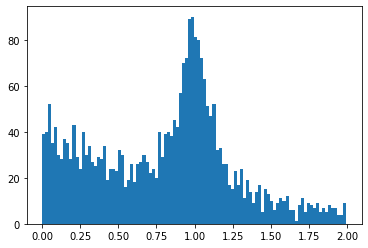

In [2]:
rng = np.random.default_rng(1)

x = 0.1 * rng.standard_t(2, size=1000) + 1
x = np.append(x, rng.exponential(size=2000))
x = x[(0 < x) & (x < 2)]

plt.hist(x, bins=100);

In [3]:
def model(x, ns, df, mu, sigma, nb, tau):
    return ns + nb, ns * t.pdf(x, df, mu, sigma) + nb * truncexpon.pdf(
        x, 0, 2, 0, tau)


cost = ExtendedUnbinnedNLL(x, model)

m = Minuit(cost, ns=1000, nb=2000, df=2, mu=1, sigma=0.1, tau=1)
m.limits["ns", "nb", "sigma", "tau"] = (0, None)
m.limits["df"] = (1, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3.516e+04                 │              Nfcn = 170              │
│ EDM = 8.76e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │    930    │    50     │            │            │    0    │         │       │
│ 1 │ df    │    3.9    │    1.0    │            │            │    1    │         │       │
│ 2 │ mu    │   0.997   │   0.005   │            │            │         │         │       │
│ 3 │ sigma │   0.103   │   0.006   │            │            │    0    │         │       │
│ 4 │ nb    │  1.80e3   │  0.06e3   │            │            │    0    │         │       │
│ 5 │ tau   │   1.04    │   0.05    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │        ns        df        mu     sigma        nb       tau │
├───────┼─────────────────────────────────────────────────────────────┤
│    ns │  2.35e+03     -15.2  -0.00921     0.111 -1.42e+03    -0.899 │
│    df │     -15.2      1.12  5.06e-05    0.0024      15.2   0.00981 │
│    mu │  -0.00921  5.06e-05  2.78e-05 -8.34e-07   0.00921 -2.34e-05 │
│ sigma │     0.111    0.0024 -8.34e-07   4.2e-05    -0.111  -6.9e-05 │
│    nb │ -1.42e+03      15.2   0.00921    -0.111  3.22e+03     0.899 │
│   tau │    -0.899   0.00981 -2.34e-05  -6.9e-05     0.899   0.00296 │
└───────┴─────────────────────────────────────────────────────────────┘

In [4]:
%%timeit
t.logpdf(x, 2, 0, 1)

33.4 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
%%timeit
t.pdf(x, 2, 0, 1)

48.5 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [6]:
%%timeit
truncexpon.logpdf(x, 0, 2, 0, 1)

8.57 µs ± 123 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
%%timeit
truncexpon.pdf(x, 0, 2, 0, 1)

25.2 µs ± 956 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
@nb.njit
def logaddexp(a, b):
    r = np.empty_like(a)
    for i in range(len(a)):
        ai = a[i]
        bi = b[i]
        if ai < bi:
            r[i] = ai + np.log1p(np.exp(bi - ai))
        else:
            r[i] = bi + np.log1p(np.exp(ai - bi))
    return r


def model_log(x, ns, df, mu, sigma, nb, tau):
    return ns + nb, logaddexp(
        np.log(ns) + t.logpdf(x, df, mu, sigma),
        np.log(nb) + truncexpon.logpdf(x, 0, 2, 0, tau))


cost_log = ExtendedUnbinnedNLL(x[(0 < x) & (x < 2)], model_log, log=True)

m_log = Minuit(cost_log, ns=1000, nb=2000, df=2, mu=1, sigma=0.1, tau=1)
m_log.limits["ns", "nb", "sigma", "tau"] = (0, None)
m_log.limits["df"] = (1, None)
m_log.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3.516e+04                 │              Nfcn = 170              │
│ EDM = 8.76e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │    930    │    50     │            │            │    0    │         │       │
│ 1 │ df    │    3.9    │    1.0    │            │            │    1    │         │       │
│ 2 │ mu    │   0.997   │   0.005   │            │            │         │         │       │
│ 3 │ sigma │   0.103   │   0.006   │            │            │    0    │         │       │
│ 4 │ nb    │  1.80e3   │  0.06e3   │            │            │    0    │         │       │
│ 5 │ tau   │   1.04    │   0.05    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │        ns        df        mu     sigma        nb       tau │
├───────┼─────────────────────────────────────────────────────────────┤
│    ns │  2.35e+03     -15.2  -0.00921     0.111 -1.42e+03    -0.899 │
│    df │     -15.2      1.12  5.06e-05    0.0024      15.2   0.00981 │
│    mu │  -0.00921  5.06e-05  2.78e-05 -8.34e-07   0.00921 -2.34e-05 │
│ sigma │     0.111    0.0024 -8.34e-07   4.2e-05    -0.111  -6.9e-05 │
│    nb │ -1.42e+03      15.2   0.00921    -0.111  3.22e+03     0.899 │
│   tau │    -0.899   0.00981 -2.34e-05  -6.9e-05     0.899   0.00296 │
└───────┴─────────────────────────────────────────────────────────────┘

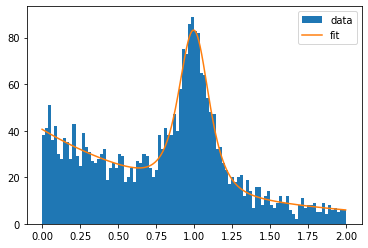

In [9]:
xm = np.linspace(np.min(x), np.max(x), 1000)
ntot, ym = model(xm, *m.values)
ym *= 2 / 100

plt.hist(x, bins=100, range=(0, 2), label="data")
plt.plot(xm, ym, label="fit")
plt.legend()

In [10]:
%%timeit ; m.reset()
m.migrad()

3.36 ms ± 89.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit ; m_log.reset()
m_log.migrad()

3.9 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
rng = np.random.default_rng(1)
valids = np.empty(1000)
for i in range(len(valids)):
    m.reset()
    
    ns = rng.exponential(1000)
    df = 1 + rng.exponential(1)
    mu = rng.normal(1, 0.25)
    sigma = rng.exponential(0.1)
    nb = rng.exponential(2000)
    tau = rng.exponential(1)

    m.values = (ns, df, mu, sigma, nb, tau)
    m.migrad()
    valids[i] = m.valid
    if i % 10 == 1:
        print(np.mean(valids[:i]))
print(np.mean(valids))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9947643979057592
0.9950248756218906
0.995260663507109
0.995475113122172
0.9956709956709957
0.991701244813278
0.9920318725099602
0.9923371647509579
0.992619926199262
0.9928825622775801
0.993127147766323
0.9933554817275747
0.9935691318327974
0.9937694704049844
0.9909365558912386
0.9882697947214076
0.9886039886039886
0.9889196675900277
0.9865229110512129
0.9868766404199475
0.9872122762148338
0.9875311720698254
0.9878345498783455
0.9881235154394299
0.988399071925754
0.9886621315192744
0.9889135254988913
0.9891540130151844
0.9893842887473461
0.9896049896049897
0.9877800407331976
0.9880239520958084
0.9882583170254403
0.9865642994241842
0.9868173258003766
0.9870609981515711
0.9872958257713249
0.9875222816399287
0.9877408056042032
0.9879518072289156
0.988155668358714
0.9883527454242929
0.9885433715220949
0.9887278582930756
0.9889064976228209
0.9890795631825273
0.989247311827957
0.989409984871407
0.9895678092399404
0.

In [29]:
rng = np.random.default_rng(1)
valids = np.empty(1000)
for i in range(len(valids)):
    m_log.reset()
    
    ns = rng.exponential(1000)
    df = 1 + rng.exponential(1)
    mu = rng.normal(1, 0.25)
    sigma = rng.exponential(0.1)
    nb = rng.exponential(2000)
    tau = rng.exponential(1)

    m_log.values = (ns, df, mu, sigma, nb, tau)
    m_log.migrad()
    valids[i] = m_log.valid
    if i % 10 == 1:
        print(np.mean(valids[:i]))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9859154929577465
0.9876543209876543
0.989010989010989
0.9900990099009901
0.990990990990991
0.9834710743801653
0.9847328244274809
0.9858156028368794
0.9867549668874173
0.9875776397515528
0.9883040935672515
0.988950276243094
0.9842931937172775
0.9850746268656716
0.985781990521327
0.9864253393665159
0.987012987012987
0.9875518672199171
0.9840637450199203
0.9846743295019157
0.985239852398524
0.9857651245551602
0.9862542955326461
0.9867109634551495
0.9871382636655949
0.9875389408099688
0.9848942598187311
0.9853372434017595
0.9857549857549858
0.9861495844875346
0.9865229110512129
0.9868766404199475
0.9872122762148338
0.9875311720698254
0.9878345498783455
0.9881235154394299
0.988399071925754
0.9863945578231292
0.9866962305986696
0.9869848156182213
0.9872611464968153
0.9875259875259875
0.9857433808553971
0.9860279441117764
0.9863013698630136
0.9846449136276392
0.9849340866290018
0.9852125693160814
0.985480943738657
0.9857397504456328
0.9859894921190894
0.986230636